In [1]:
import sys
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np 
import os
import pandas as pd

import torch
from torch_geometric.utils import add_self_loops, degree

sys.path.append("..")

from spikeometric.models import BernoulliGLM
from spikeometric.datasets import NormalGenerator, ConnectivityDataset, UniformGenerator
from spikeometric.stimulus import RegularStimulus
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, to_networkx
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Create dataset

In [8]:
n_neurons = 4
n_networks = 1

mu=0
sigma=10
theta = 5

generator = NormalGenerator(
    n_neurons=n_neurons,
    mean=mu,
    std=sigma,
    glorot=True,
    sparsity=0.5
)

#load connectivity matricies
network_data = generator.generate(n_networks)

# set up the neuron model
neuron_model = BernoulliGLM(
    theta=theta,
    dt=1.,
    coupling_window=2,
    abs_ref_scale=0,
    abs_ref_strength=-100,
    rel_ref_scale=0,
    rel_ref_strength=-30,
    alpha=5,
    beta=0
)

In [3]:
network_data[0].W0

tensor([ 5.7843,  6.2625,  9.6238, -1.5342, -7.3525, -5.2876])

#### Construct own network

In [2]:
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 0],
                           [1, 2]])

W0 = torch.tensor([6.0, -5.5])

dataset = Data(num_nodes=3, W0=W0, edge_index=edge_index)

torch.save(dataset,'data/homemade.pt')
print(edge_index.shape, W0.shape)

torch.Size([2, 2]) torch.Size([2])


#### Visualise network

In [3]:
dataset = torch.load('data/homemade.pt')

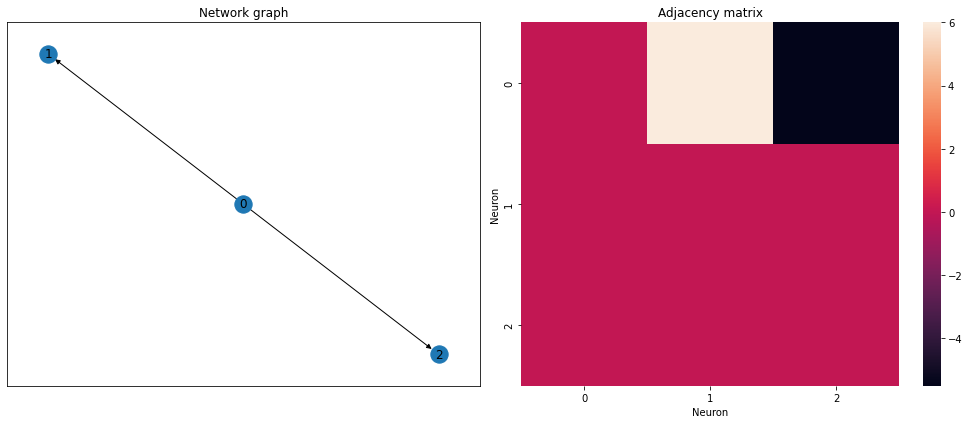

In [4]:
# visualisation of one of the networks generated
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

#example_network = network_data[0]

example_network = dataset

G = to_networkx(example_network)
nx.draw_networkx(G, arrows=True, ax=ax[0])
ax[0].set_title("Network graph")

W0 = to_dense_adj(example_network.edge_index, edge_attr=example_network.W0, max_num_nodes=example_network.num_nodes)[0]
sns.heatmap(W0, ax=ax[1])
ax[1].set_title("Adjacency matrix")
ax[1].set_xlabel("Neuron")
ax[1].set_ylabel("Neuron")

plt.tight_layout()
plt.show()

In [5]:
#neuron_model.tune(example_network, firing_rate=10, tunable_parameters=['theta', 'alpha'])

#### Run the simulation

In [9]:
n_timesteps = 10**5
spikes = neuron_model.simulate(example_network, n_steps=n_timesteps, verbose=False)

#### Plot the activity

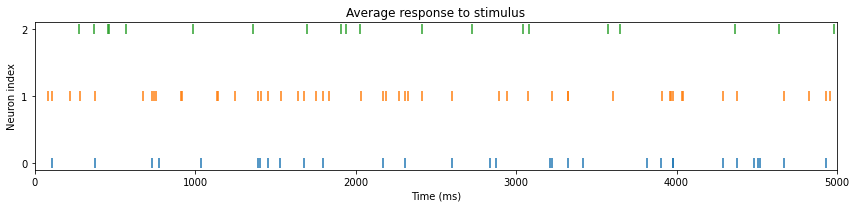

In [10]:
# Plot the results
#plt.imshow(spikes, aspect="auto", cmap="binary", interpolation="none")
plt.figure(figsize=(12,3))

plt.scatter(np.where(spikes[0,:] == 1)[0], np.zeros_like(np.where(spikes[0,:] == 1)[0]), marker='|', s=100)
plt.scatter(np.where(spikes[1,:] == 1)[0], np.ones_like(np.where(spikes[1,:] == 1)[0]), marker='|', s=100)
plt.scatter(np.where(spikes[2,:] == 1)[0], 2*np.ones_like(np.where(spikes[2,:] == 1)[0]), marker='|', s=100)

plt.yticks([0,1,2])
plt.xlabel("Time (ms)")
plt.ylabel("Neuron index")
plt.xlim([0,5000])
plt.ylim([-0.1,2.1])
plt.title("Average response to stimulus")
plt.tight_layout()
plt.show()

### Learn structure with linear regression

In [10]:
print(W0)
#theta = 2.7760
true_effect = torch.sigmoid(W0 - torch.tensor(theta)) - torch.sigmoid(-torch.tensor(theta))
print(true_effect)

tensor([[ 0.0000,  6.0000, -5.5000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000]])
tensor([[ 0.0000,  0.7244, -0.0067],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000]])


In [11]:
target_neuron = 2
X = spikes[:target_neuron]
y = spikes[target_neuron]
print(X.shape, y.shape)

torch.Size([2, 100000]) torch.Size([100000])


In [12]:
X

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)

In [15]:
linear_model = LinearRegression()
linear_model.fit(X.T, torch.roll(y, -1).T)
print(linear_model.coef_)
#linear_model.predict(torch.tensor([1]).reshape(-1, 1)) - linear_model.predict(torch.tensor([0]).reshape(-1, 1))

[-0.00651391 -0.00019087]


In [20]:
y_rolled = torch.roll(y, -1)
y2 = np.array(y_rolled)
expected_y = torch.mean(y_rolled[X[0] == 1], dtype=torch.float) - torch.mean(y_rolled[X[0] == 0], dtype=torch.float)
#print(expected_y)
#print(true_effect[0, target_neuron])

X2 = np.array(sm.add_constant(X.T))

#print(y2.shape, X2.shape)
linear_model = sm.OLS(y2.T, np.array(sm.add_constant(X.T)))
results = linear_model.fit()
print(np.round(results.pvalues, 4))
#results.summary()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
[0.     0.0382 0.9371]


In [194]:
effect_predicted

array([ 0.00667708, -0.0066901 ,  0.0027136 ])

### Now try to learn with stimulus

In [25]:
stimulus_masks = torch.tensor([0, 1, 0], dtype=torch.bool) # stimulerer nevron 1
neuron_model.add_stimulus(lambda t: 2*(t % 1000 < 200)*stimulus_masks)

In [26]:
spikes = neuron_model.simulate(example_network, n_steps=n_timesteps, verbose=False)

In [30]:
n_neurons = 3
stimulus_feature = torch.zeros((n_neurons, n_timesteps))

In [31]:
stimulus = lambda t: (t % 1000 < 200)*stimulus_masks

In [32]:
for t in range(n_timesteps):
    stimulus_feature[:,t] = stimulus(t) 

In [33]:
X = spikes[:target_neuron]

In [39]:
stimulus_feature[1] == 1

tensor([ True,  True,  True,  ..., False, False, False])

In [40]:
X1 = X[:, stimulus_feature[1] == 1]

In [41]:
y_rolled = torch.roll(spikes[target_neuron], -1)

In [42]:
y1 = y_rolled[stimulus_feature[1] == 1]

In [43]:
print(y1.shape, X1.shape)

torch.Size([20000]) torch.Size([2, 20000])


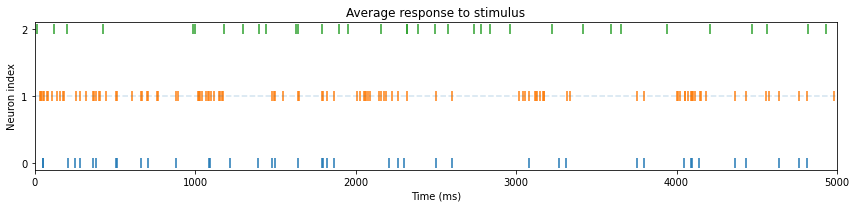

In [47]:
# Plot the results
#plt.imshow(spikes, aspect="auto", cmap="binary", interpolation="none")
plt.figure(figsize=(12,3))
plt.hlines(np.where(stimulus_masks == True)[0], 0, n_timesteps, linestyles='dashed', alpha=0.2)
plt.scatter(np.where(spikes[0,:] == 1)[0], np.zeros_like(np.where(spikes[0,:] == 1)[0]), marker='|', s=100)
plt.scatter(np.where(spikes[1,:] == 1)[0], np.ones_like(np.where(spikes[1,:] == 1)[0]), marker='|', s=100)
plt.scatter(np.where(spikes[2,:] == 1)[0], 2*np.ones_like(np.where(spikes[2,:] == 1)[0]), marker='|', s=100)

plt.yticks([0,1, 2])
plt.xlabel("Time (ms)")
plt.ylabel("Neuron index")
plt.xlim([0,5000])
plt.ylim([-0.1,2.1])
plt.title("Average response to stimulus")
plt.tight_layout()
plt.show()

In [76]:
#linear_model = LinearRegression()
#linear_model.fit(X1.T, y1.T)
#print(linear_model.coef_)
#print(true_effect[0,1])

LinearRegression()

In [48]:
y2 = np.array(y1)
X2 = np.array(sm.add_constant(X1.T))
print(X2.shape, y2.shape)
linear_model = sm.OLS(y2.T, X2)
results = linear_model.fit()
effect_predicted = results.params

(20000, 3) (20000,)
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [49]:
print(effect_predicted)
results.summary()

[ 0.00657339 -0.00641971 -0.00257402]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9354
Date:                Mon, 06 Nov 2023   Prob (F-statistic):              0.392
Time:                        13:37:16   Log-Likelihood:                 22201.
No. Observations:               20000   AIC:                        -4.440e+04
Df Residuals:                   19997   BIC:                        -4.437e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0066      0.001     11.323      0.000       0.005       0.008
x1            -0.0064      0.007     -0.929      0.353      -0.020       0.007
x2            -0.0026      0.003     -1.001      0.317      -0.008       0.002
==============================================================================
Omnibus:                    34362.897   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         19568910.040
Skew:                          12.378   Prob(JB):                         0.00
Kurtosis:                     154.228   Cond. No.                         12.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [194]:
df

,0,1
0,0,0
1,0,0
2,0,0
3,1,0
4,0,1
...,...,...
99995,0,0
99996,0,0
99997,0,0
99998,0,0


In [50]:
ATE = torch.mean(y[stimulus_feature[1] == 1], dtype=torch.float) - torch.mean(y[stimulus_feature[1] == 0], dtype=torch.float) 
print(ATE)

tensor(-0.0006)


In [51]:
y[stimulus_feature[0] == 1]

tensor([], dtype=torch.int32)

In [52]:
ATE

tensor(-0.0006)